In [20]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from glob import glob
from imutils.object_detection import non_max_suppression
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

[INFO] loading EAST text detector...


In [8]:
def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [35]:
min_confidence = 0.9
padding = 1

OCR TEXT
vegies

OCR TEXT
Mand

OCR TEXT
_ Neat. Mus, Aarh,

OCR TEXT
LN eZ Maca



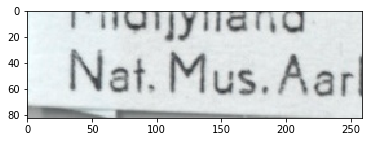

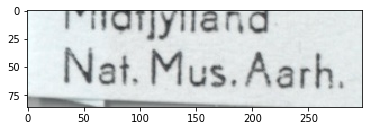

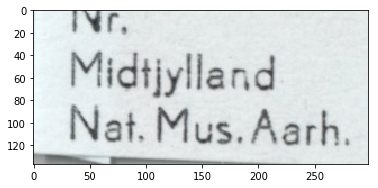

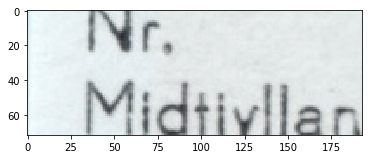

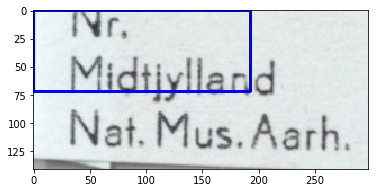

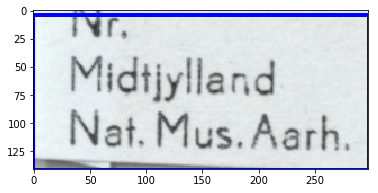

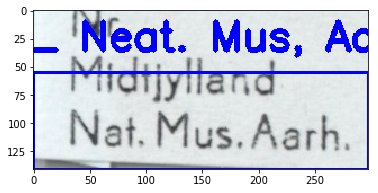

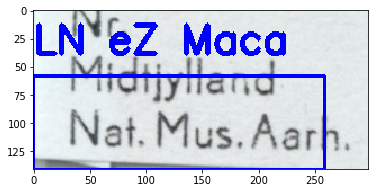

In [36]:
fps = glob('/home/rob/HWR/datasets/Aarhus/yolo_labels/*.jpg')
fps = np.random.permutation(fps)
image = cv2.imread(fps[0])
orig = image.copy()
(origH, origW) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = origW / float(newW)
rH = origH / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]


blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
 
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)


# initialize the list of results
results = []

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * padding)
    dY = int((endY - startY) * padding)

    # apply padding to each side of the bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))

    # extract the actual padded ROI
    roi = orig[startY:endY, startX:endX]
    plt.figure()
    plt.imshow(roi)
    
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)

    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((startX, startY, endX, endY), text))

# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])

# loop over the results
for ((startX, startY, endX, endY), text) in results:
    # display the text OCR'd by Tesseract
    print("OCR TEXT")
    print("========")
    print("{}\n".format(text))

    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    output = orig.copy()
    cv2.rectangle(output, (startX, startY), (endX, endY),
        (0, 0, 255), 2)
    cv2.putText(output, text, (startX, startY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    # show the output image
    plt.figure()
    plt.imshow(output)

In [24]:
fps[0]

'/home/rob/HWR/datasets/Aarhus/yolo_labels/199357_1_HWR.jpg'